# Seminar 3 (Data embedding)

The goal of this seminar is to play around with diffrent techniques for data visualization. We are going work on the well-known  [MNIST](http://yann.lecun.com/exdb/mnist/). The dataset consists of 60,000 grayscale images of hand-written digits of size 28 $ \times $ 28. Thus, the dimensionality of the input space is **784**.

In [1]:
%matplotlib inline
from time import time
import numpy as np
import matplotlib.pyplot as plt

## Visualizing MNIST

As usual we provide the code that fetches the data:

In [2]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("MNIST original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

Now it's your turn to plot some random representatives from each of 10 (obviously) available classes:

Dimensions: (70000, 784)


/Library/Python/2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


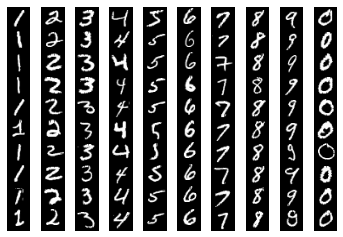

In [3]:
# Preferably arrange images as a 10x10 matrix.

print("Dimensions: {}".format(X.shape))

fig = plt.figure()

for c in range(10):
    Xc = X[y == c][:10]
    for i in range(10):
        ax = plt.subplot(10, 10, i * 10 + c)
        plt.imshow(Xc[i].reshape((28, 28)), cmap=plt.gray())
        plt.subplots_adjust(hspace = .001)
        ax.set_xticklabels(())
        ax.set_yticklabels(())

The whole dataset is somewhat large so we restrict ourselves to the random subset of 5,000 images (corresponding indices are held in ``train_indices``):

In [4]:
n_train_samples = 5000

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_indices = indices[: n_train_samples]
X_train = X[train_indices]
y_train = y[train_indices]

### PCA, Multidimensional scaling (MDS) and Locally Linear Embedding (LLE)

Your task is to try three different dimensionality reduction techniques which may be helpful for the visualization of high-dimensional data. The first one should be familiar to you: it's **PCA** with 2 components. The other two are non-linear embedding approaches described in the lecture, namely, [MDS](http://en.wikipedia.org/wiki/Multidimensional_scaling) and [LLE](http://web.stanford.edu/class/ee378b/papers/roweis.pdf). Plot all three embeddings and check if they are good enough for the dataset.

**NOTE:** MDS (default settings) may take some time (>10 min) to compute, so be patient. It's probably a good idea to leave the exploration of this method as a hometask. 

In [5]:
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import MDS, LocallyLinearEmbedding

# Your code goes here.

svd = TruncatedSVD(n_components=2, random_state=42)
svd.fit(X_train)

print(svd.explained_variance_ratio_)

[ 0.05864633  0.08251498]


In [6]:
X_svd = svd.transform(X_train)

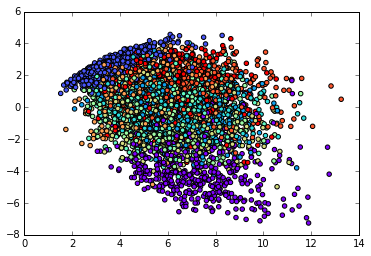

In [7]:
def plot_points(X, y, ax=plt):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap('rainbow'))

plot_points(X_svd, y_train)

### Isomap

Now we are going to explore the manifold of **2**'s using [Isomap](http://web.mit.edu/cocosci/Papers/sci_reprint.pdf). First, you need to compute the embedding of the corresponding subset of MNIST.

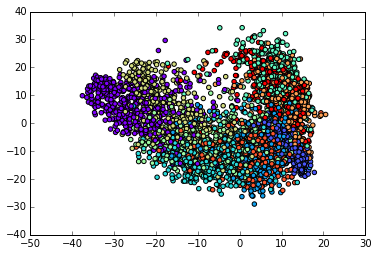

In [8]:
from sklearn.manifold import Isomap

indices_of_2 = np.arange(X.shape[0])[y == 2]
np.random.shuffle(indices_of_2)
train_indices_of_2 = indices_of_2[: n_train_samples]

# Your code goes here.

isomap = Isomap()
isomap.fit(X_train)
X_isomap = isomap.transform(X_train)
plot_points(X_isomap, y_train)

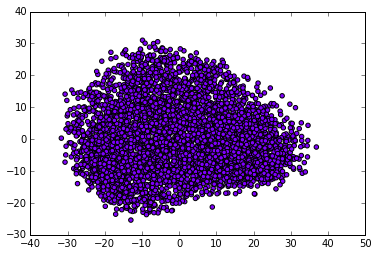

In [9]:
X_train_2 = X[train_indices_of_2]
y_train_2 = y[train_indices_of_2]

isomap_2 = Isomap()
isomap_2.fit(X_train_2)
X_isomap_2 = isomap_2.transform(X_train_2)
plot_points(X_isomap_2, y_train_2)

After it is done we can track how an appearance of the digit changes along the line. One can take two most distant points as the endpoints of the interpolation segment. The following code should extract closest points to the line. Use **``scipy.spatial.KDTree``** for the fast nearest neighbour computation.

In [10]:
from scipy.spatial import KDTree
from scipy.spatial.distance import pdist, cdist, squareform
from scipy import linspace

def find_representatives(kdtree, from_point, to_point, n_points):
    # Given two 2D points this function should return a sequence of the dataset representatives (indices) that
    # we encounter nearby as we go from from_point to to_point. This can be done by taking a set points on 
    # the segment and finding corresponding nearest neighbours in the dataset.
    
    # Your code goes here.
    representatives = []
    
    for i in range(n_points):
        t = 1.0 * i / (n_points - 1)
        p = (1 - t) * from_point + t * to_point
        representatives.append(kdtree.query(p)[1])
    
    return representatives

n_points = 100

# Your code starts here and should end with:
kdtree = KDTree(X_isomap_2)

import scipy

dist = scipy.spatial.distance.cdist(X_isomap_2, X_isomap_2)
from_idx, to_idx = np.unravel_index(dist.argmax(), dist.shape)

print("Most distant pair: dist({}, {}) = {}".format(from_idx, to_idx, dist[from_idx, to_idx]))

representatives = find_representatives(kdtree, X_isomap_2[from_idx, :], X_isomap_2[to_idx, :], n_points)

Most distant pair: dist(3425, 3499) = 69.5531547926


In [11]:
print(X_isomap_2[from_idx, :])
print(X_isomap_2[to_idx, :])

[ 36.85358181  -2.47102289]
[-30.69187296  14.11972394]


Now we define a bunch of helper functions for interpolation visualization. Note the **`diplay_manifold_flythrough`** function. First two arguments are array of images and their coordinates on the 2D plane.

In [12]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

from base64 import b64encode

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def save_anim(anim, filename):
    anim.save(filename, fps=5, extra_args=['-vcodec', 'libx264'], writer='ffmpeg')

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        save_anim(anim, "temp.mp4")
        with open('temp.mp4', 'rb') as f:
            video = f.read()
        anim._encoded_video = b64encode(video)
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close()
#     return HTML(anim_to_html(anim))

def diplay_manifold_flythrough(X, coords, fig, ax, filename):
    imagebox = OffsetImage(X[0].reshape(28, 28), cmap=plt.cm.gray_r, zoom=2)
    annbox = AnnotationBbox(imagebox, coords[0])
    ax.add_artist(annbox)

    def init():
        return imagebox, annbox

    def animate(i):
        imagebox.set_data(X[i].reshape(28, 28))
        annbox.xyann = coords[i]

        return imagebox, annbox

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=X.shape[0], interval=20, blit=True)
    save_anim(anim, filename)
    
    return display_animation(anim)

Now use **`diplay_manifold_flythrough`** to display the manifold fly-through over the scatter plot of the subset:

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())

plot_points(X_isomap_2, y_train_2, ax)

# Your code starts here and should end with:
diplay_manifold_flythrough(X_train_2[representatives], X_isomap_2[representatives], fig, ax, "flythrough_isomap.mp4")

Additionally create an animation of the interpolation. Specifically, you should obtain an animation similar to the one presented below:

In [14]:
def display_interpolation(X, steps, fig, filename):
    # NOTE: First argument corresponds to the sequence of images.
    
    n_images = X.shape[0]
    
    im = plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.gray_r)

    def init():
        return im,
    
    def animate(i):
        # Your code goes here.
        img_index = n_images * i // steps
        img = X[img_index].reshape((28, 28))
        im.set_array(img)
        return im,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=steps, interval=20, blit=True)
    anim.save(filename, fps=20, extra_args=['-vcodec', 'libx264'], writer='ffmpeg')
    
    return display_animation(anim)

fig = plt.figure(figsize=(3, 3))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())

# Your code starts here and should end with:
display_interpolation(X_train_2[representatives], 500, fig, "interpolation_isomap.mp4")

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

If we need to visualize the whole set of digits, a much better embedding technique is [t-SNE](http://lvdmaaten.github.io/tsne/). This method has been proven to generate high-quality visualizations in various scenarios and has become a standard de-facto in analyzing high-dimensional data (like activities of neurons in an Artificial Neural Network). We are going to use a slower version of the algorithm supplied in the ``scikit-learn`` (**``sklearn.manifold.TSNE``**). In practice, however, I'd suggest to use an approximate [Barnes-Hut t-SNE](http://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf) which produces comparable results while working substantially faster.

Your task here is similar to the ones in the previous section. The differeces are:
* You should use all digits (a ``train_indices`` subset)
* The fly-through should capture all classes. One way to achieve this would be to use picker capabilities of ``matplotlib`` ([demo](http://matplotlib.org/examples/event_handling/pick_event_demo.html)) in order to manually pick a sequence of keypoints on a scatter plot. Given a list of keypoints, it's easy to obtain intermediate representatives using the **``find_representatives``** function. The rest of the code should be almost identical to the Isomap-case. **Don't forget about the interpolation animation :)**

**NOTE 1:** t-SNE is available in the latest version of ``scikit-learn``. There is a ``python`` package called ``bh_tsne`` which implements Barnes-Hut t-SNE. Feel free to use that one.

**NOTE 2:** It may be a good idea to apply PCA (with, for example, 50 components) to the data first.

In [15]:
from sklearn.manifold import TSNE

# Your code goes here.
X_tsne = TSNE(verbose=True).fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.087351
[t-SNE] Error after 89 iterations with early exaggeration: 19.717556
[t-SNE] Error after 328 iterations: 2.281785


### Without PCA

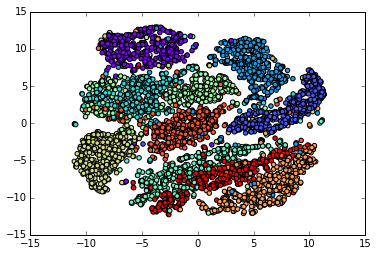

In [16]:
plot_points(X_tsne, y_train)

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Your code goes here.
X_pca = PCA(n_components=50).fit_transform(X_train)
X_pca_tsne = TSNE(verbose=True).fit_transform(X_pca)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.875932
[t-SNE] Error after 83 iterations with early exaggeration: 19.154458
[t-SNE] Error after 322 iterations: 2.277904


### With PCA, n_components=50

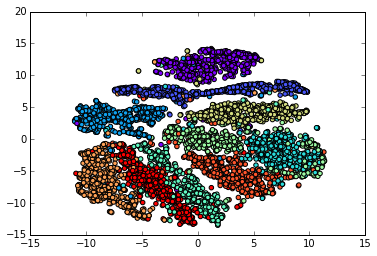

In [18]:
plot_points(X_pca_tsne, y_train)

In [19]:
from tsne import bh_sne
X_pca_bh_sne = bh_sne(X_pca)

### BH tsne

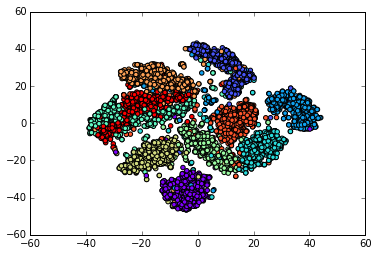

In [20]:
plot_points(X_pca_bh_sne, y_train)

In [21]:
n_points = 100

# Your code starts here and should end with:
kdtree = KDTree(X_tsne)

import scipy

dist = scipy.spatial.distance.cdist(X_tsne, X_tsne)
from_idx, to_idx = np.unravel_index(dist.argmax(), dist.shape)

print("Most distant pair: dist({}, {}) = {}".format(from_idx, to_idx, dist[from_idx, to_idx]))

representatives = find_representatives(kdtree, X_tsne[from_idx, :], X_tsne[to_idx, :], n_points)

cur_dist = dist[from_idx,:] + dist[to_idx,:]
cur_idx = to_idx
for i in range(5):
    idx = cur_dist.argmax()
    representatives += find_representatives(kdtree, X_tsne[cur_idx, :], X_tsne[idx, :], n_points)
    cur_idx = idx
    cur_dist = cur_dist + dist[cur_idx,:]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())

plot_points(X_tsne, y_train, ax)

# Your code starts here and should end with:
diplay_manifold_flythrough(X_train[representatives], X_tsne[representatives], fig, ax, "flythrough_tsne.mp4")

Most distant pair: dist(1902, 2068) = 27.631731575


In [22]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())

# Your code starts here and should end with:
display_interpolation(X_train[representatives], 500, fig, "interpolation_tsne.mp4")